In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import logging
import numpy as np
from tqdm import tqdm
from seaborn import kdeplot
import matplotlib.pyplot as plt

In [4]:
from simulator.lob import OrderBookSimulator
from scripts.utils.data_loading import get_data_file_paths

In [5]:
logging.getLogger().setLevel(logging.ERROR)

In [33]:
DATA_ROOT = '../data/onetick/processed_2/AAPL'
IMPACT_PARAM = 10 ** 8  # large values execute against historic orders
DURATION = 30 * 60  # in seconds
SAMPLING_FREQUENCY = 5  # in seconds, dicated by LOB data
NUM_PERIODS = int(DURATION / SAMPLING_FREQUENCY)
PLACEMENT_FREQUENCY = 12
ORDER_SIZE = 200
BREAK_PERIOD = int(NUM_PERIODS / 2)

In [34]:
simulation_periods = get_data_file_paths(DATA_ROOT)

### Strategy which places a market sell order every PLACEMENT_FREQUENCY periods

In [35]:
calc_midprice = lambda x: (x.BID_PRICE.max() + x.ASK_PRICE.min()) / 2

In [36]:
def almgren_chris(sim_data_path, order_size=ORDER_SIZE, num_periods=NUM_PERIODS, impact_param=IMPACT_PARAM, placement_frequency=PLACEMENT_FREQUENCY, break_period=BREAK_PERIOD):
    
    try:
        
        # set up LOB simulator
        order_book_file = os.path.join(sim_data_path, 'ob.feather')
        trades_file = os.path.join(sim_data_path, 'trades.feather')
        LOB = OrderBookSimulator(order_book_file, trades_file, impact_param)

        # we will save our trade data to these lists
        order_list = []
        midprice_series = []

        for period in range(0, num_periods):

            if period == break_period:
                break
            
            # advance state
            ob, trds, executed_orders, active_limit_order_levels = LOB.iterate()

            # place sell order
            if not (period % placement_frequency):
                LOB.place_market_sell_order(100)

            # save data
            midprice_series.append(calc_midprice(ob))
            order_list += executed_orders
            
    except:
        order_list = []
        midprice_series = []
    
    return (order_list, midprice_series)

In [40]:
import multiprocessing as mp

with mp.Pool(max(1, mp.cpu_count() - 1)) as pool:
    pool_results = pool.map(almgren_chris, simulation_periods)

In [37]:
def calculate_shortfall(pool_results):
    ALL_DATA = {}
    for idx, res in enumerate(pool_results):
        if len(res[0]) == 0:
            continue
        ALL_DATA[idx] = {'price_series': res[1], 'executed_orders': res[0]}
    
    shortfall_results = []
    for sim_data_path, sim_results in ALL_DATA.items():
        vol_weighted_price_sum = sum([order['volume'] * order['price'] for order in sim_results['executed_orders']])   
        total_volume = sum([order['volume'] for order in sim_results['executed_orders']])
        vwap = vol_weighted_price_sum / total_volume
        initial_price = sim_results['price_series'][0]
        shortfall = 100 * (vwap - initial_price) / initial_price
        shortfall_results.append(shortfall)
    
    return shortfall_results

In [44]:
shortfall_fast = calculate_shortfall(pool_results)

Mean Shortfall: -0.00%
StdDev Shortfall: 0.13%


In [38]:
shortfall_slow = calculate_shortfall(pool_results)

Mean Shortfall: -0.00%
StdDev Shortfall: 0.18%


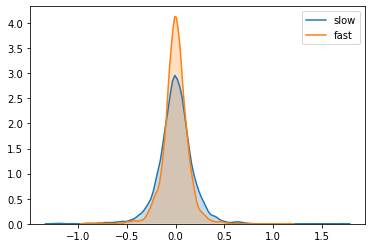

In [84]:
kdeplot(shortfall_slow, shade=True, label='slow')
kdeplot(shortfall_fast, shade=True, label='fast')

In [89]:
fast_mean = np.mean(shortfall_fast)
fast_std = np.std(shortfall_fast)
fast_se = fast_std / np.sqrt(len(shortfall_fast))
slow_mean = np.mean(shortfall_slow)
slow_std = np.std(shortfall_slow)
slow_se = slow_std / np.sqrt(len(shortfall_slow))

In [90]:
print('FAST EXECUTION')
print('Mean Shortfall: %.4f bps +/- %.4f bps' % (100 * fast_mean, 100 * fast_se))
print('StDev Shortfall: %.4f%%' % fast_std)
print()
print('SLOW EXECUTION')
print('Mean Shortfall:  %.4f bps +/-  %.4f bps' % (100 * slow_mean, 100 * slow_se))
print('StDev Shortfall:  %.4f%%' % slow_std)

FAST EXECUTION
Mean Shortfall: -0.1895 bps +/- 0.2058 bps
StDev Shortfall: 0.1299%

SLOW EXECUTION
Mean Shortfall:  -0.1154 bps +/-  0.2870 bps
StDev Shortfall:  0.1811%
